In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

## Get started with composite stacking sequence optimization

In this notebook, we show how to solve the composite stacking sequence optimization problem, which is encountered in one of the phases of composite optimization.<sup>1</sup> This problem is solved by using the quantum random access optimization (QRAO) algorithm.<sup>2</sup> Our approach consists of the following steps:

1. Set up the combinatorial problem.
2. Encode the problem into a quantum Hamiltonian. 
3. Solve the problem with the QRAO algorithm.

We start this tutorial with the setup of the optimization problem as a max-cut problem and then show how we can use the QRAO algorithm to solve it. By working through this tutorial, you will learn how to set up and solve a combinatorial optimization problem using QRAO. This prototype evolved out of research at IBM Quantum, available in Fuller et al. 2021.<sup>2</sup>

#### Import packages

This tutorial assumes the `qrao` package has already been installed according to the setup instructions. We begin by importing some useful tools from `NumPy` and `Qiskit`, including a minimum eigensolver VQE<sup>3</sup> and classical SPSA optimizer<sup>4</sup> that we use to find an approximate solution to our problem after it has been encoded using quantum random access codes into a quantum Hamiltonian.

In [2]:
import numpy as np

from qiskit_algorithms import VQE
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import SPSA
from qiskit_aer.primitives import Estimator

Next, the following packages are imported from the `qrao` module in Qiskit:
- The main QRAO classes (one to encode our problem and another to find the approximate solution via variational optimization)
- One rounding scheme (to map the ground state solution back to a solution of our original problem)<sup>5</sup>
- A utility function (to help generate random max-cut problems)<sup>6</sup> 

In [3]:
from qrao import (
    QuantumRandomAccessOptimizer,
    QuantumRandomAccessEncoding,
    SemideterministicRounding,
)
from qrao.utils import get_random_maxcut_qp

### Problem statement

The ply composite stacking problem we consider can be represented as a max-cut problem. Let’s assume we have $N$ plies that need to be 
stacked and let $a_i \in \{0,90,45,-45\}$ be the angle of the $i^{th}$ ply. These angles can be represented by two bits 
$x_i \in \{0,1\}$ and $y_i \in \{0,1\}$ according to the following table:

$$
\begin{array}{cc}
a_i & x_i y_i\\ \hline
0 & 00\\
45 & 10\\
90 & 01\\
-45 & 11\\ \hline
\end{array}
$$

The set of forbidden sequences is
$$
{\cal D} = \{(0^\circ,90^\circ),(90^\circ,0^\circ),(\mp45^\circ,\pm45^\circ),(0^\circ,0^\circ),(90^\circ,90^\circ).
(\pm45^\circ,\mp45^\circ)\}
$$
After examining the sequence above carefully, it becomes apparent that the two plies $i$ and $j$ are in a forbidden sequence 
if $x_i=x_j$. It follows that we don’t need the $y_i$ bit to model the problem. If we define a sequence
$C_{ij}=(x_i-x_j)^2=x_i + x_j - 2x_i x_j$ (given that $x_i \in \{0,1\}$ $x_i^2=x_i$), we see that the sequence is allowed when 
$x_i \ne x_j$, which translates to $C_{ij}=1$, and forbidden when $x_i=x_j$, which translates to $C_{ij}=0$. Let’s assume that each 
sequence $C_{ij}$ carries also a weight $w_{ij}$. So, given a set ${\cal C}$ of possible sequences between pairs of plies,
we want to maximize $\sum_{C_{ij} \in {\cal C}} w_{ij}C_{ij}$. We can define this problem on a graph $G=(V,E)$ that has $|V|=N$ 
nodes (corresponding to plies) and $|E|=|{\cal C}|$ edges (corresponding to possible pairs of plies). The optimization problem is therefore equivalent to finding a (weighted) max cut on this graph. This is 
so because: 
$$
\sum_{C_{ij} \in {\cal C}} w_{ij} C_{ij} = \sum_{(i,j) \in E} w_{ij}(x_i+x_j - 2x_i x_j)= 
\sum_{(i,j) \in E} \frac{1}{2}w_{ij}(1-z_i z_j),
$$
where the last equality is derived by substituting $x_i=\frac{1-z_i}{2}$ with $z_i \in \{-1,1\}$. This is precisely the 
max-cut problem on the graph $G$.<sup>1</sup> 

For simplicity, in this tutorial, we will consider a random max-cut problem instance and use QRAO to try to find a maximum cut—in other words, a partition of the graph’s vertices (plies) into two sets that maximizes the number of edges (sequences) between the sets.

First, we use the utility function `get_random_maxcut_qp` to specify the graph (degree and number of nodes) and generate a `QuadraticProgram` of the correct type.<sup>5,6</sup> The latter is a class from `qiskit-optimization` that we use to make a model of our optimization problem.

Once our problem has been represented as a `QuadraticProgram`, it will need to be converted to the correct type, a quadratic unconstrained binary optimization (QUBO) problem, so that it is compatible with QRAO (as well as with optimization algorithms from `qiskit-optimization`).<sup>7</sup>

Our utility function handles all of this automatically for us, but if you define your own problem, be sure you convert it to a QUBO 
before proceeding. Here is 
[a tutorial](https://qiskit.org/documentation/optimization/tutorials/02_converters_for_quadratic_programs.html) on converting 
`QuadraticPrograms`.

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: maxcut

Maximize
 obj: 6 x0 + 6 x1 + 6 x2 + 6 x3 + 6 x4 + 6 x5 + [ - 8 x0*x1 - 8 x0*x3 - 8 x0*x5
      - 8 x1*x2 - 8 x1*x4 - 8 x2*x3 - 8 x2*x5 - 8 x3*x4 - 8 x4*x5 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1

Binaries
 x0 x1 x2 x3 x4 x5
End



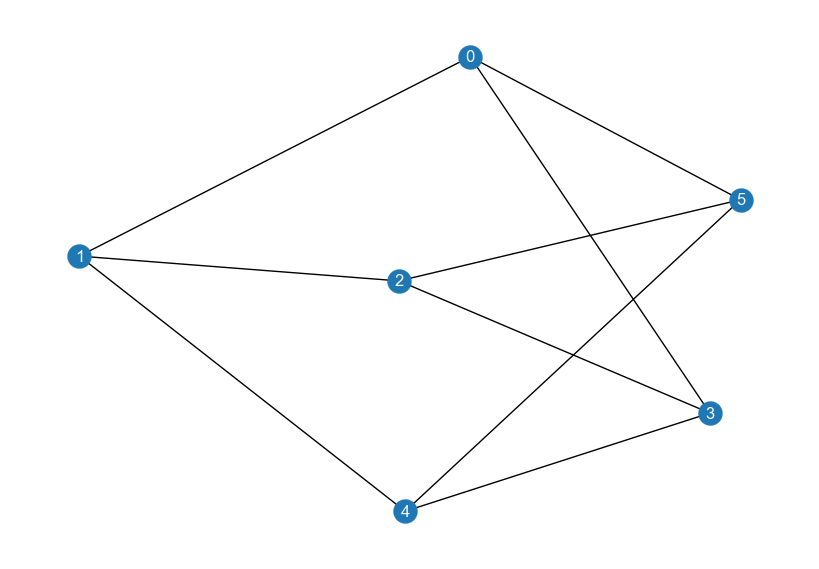

In [4]:
# Generate a random QUBO in the form of a QuadraticProgram
problem = get_random_maxcut_qp(degree=3, num_nodes=6, seed=3, draw=True)
print(problem.export_as_lp_string())

### Encode the problem into a quantum Hamiltonian

Once our problem is correctly configured, we use `QuantumRandomAccessEncoding` from the `qrao` library to generate the Hamiltonian operator that encodes our problem. In particular, we use a quantum random access code (QRAC) to encode multiple classical binary variables (nodes of our max-cut graph) into each qubit. Importantly, the “relaxed” Hamiltonian produced by this encoding will _not_ be diagonal. This is in contrast to the standard workflow in `qiskit-optimization`, which produces a diagonal (Ising) Hamiltonian that can be solved with a `MinimumEigenOptimizer`.<sup>8</sup>

Here, we use a $(3,1,p)-$ QRAC, which means that for a given input problem we can encode a _maximum_ of three classical binary variables into each qubit ($p$ represents the bit recovery probability via a measurement). Depending on the problem, some qubits may have fewer than three qubits assigned to them. We can check the ratio of number of original binary variables to qubits with the `compression_ratio` attribute of the encoding (which is, at best, a factor of 3).

In [17]:
# Create an encoding object with a maximum of 3 variables per qubit, aka a (3,1,p)-QRAC
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)

# Encode the QUBO problem into an encoded Hamiltonian operator
encoding.encode(problem)

# This is our encoded operator
print(f"Our encoded Hamiltonian is:\n( {encoding.qubit_op} ).\n")
print(
    "We achieve a compression ratio of "
    f"({encoding.num_vars} binary variables : {encoding.num_qubits} qubits) ≈ {encoding.compression_ratio}.\n"
)

Our encoded Hamiltonian is:
( 2.9999999999999996 * XX
+ 2.9999999999999996 * XY
+ 2.9999999999999996 * XZ
+ 2.9999999999999996 * YX
+ 2.9999999999999996 * ZX
+ 2.9999999999999996 * YY
+ 2.9999999999999996 * YZ
+ 2.9999999999999996 * ZY
+ 2.9999999999999996 * ZZ ).

We achieve a compression ratio of (6 binary variables : 2 qubits) ≈ 3.0.



### Solve the problem using the `QuantumRandomAccessOptimizer`

Now that we have encoded our input problem as a relaxed Hamiltonian, we use the `QuantumRandomAccessOptimizer` to find an approximate solution to the relaxed problem.

To set up the optimizer, we specify a minimum eigensolver to heuristically search for the ground state of the relaxed problem Hamiltonian. Here, we use the VQE as an example, but QAOA can be used as well.<sup>9</sup> We’ll use a Qiskit Aer simulator, but a quantum device could alternatively be selected as the backend.

Additionally, we specify a rounding scheme to map the ground state results back to a solution of the original problem. Here, we use semideterministic rounding, which is also the default if left unspecified.

In [18]:
run_options =  {"shots":1024}
estimator = Estimator(run_options=run_options)
# Set up the variational quantum eigensolver (ansatz width is determined by the encoding)
vqe = VQE(
    ansatz=RealAmplitudes(encoding.num_qubits),
    optimizer=SPSA(maxiter=50),
    estimator=estimator,
)

# Use semideterministic rounding, known as "Pauli rounding" in https://arxiv.org/pdf/2111.03167v2.pdf
# This is the default if no rounding scheme is specified
rounding_scheme = SemideterministicRounding()

# Construct the optimizer
qrao = QuantumRandomAccessOptimizer(
    encoding=encoding, min_eigen_solver=vqe, rounding_scheme=rounding_scheme
)

Finally, we solve the problem. This give us access to a dictionary of results. Whether or not the problem was executed without errors is indicated by **`status`**. Currently, if the problem executed without raising an exception, the **`status`** will be set to **`SUCCESS`**.

The **`optimal value`** contains the binary values of the best found solution and **`optimal function value`** contains the best found solution’s objective value. Note that the ordering of variables in **`optimal value`** matches the numbering of nodes in the original graph.

Note that the word *optimal* is used here to be consistent with the `qiskit-optimization` module’s naming conventions. In practice, you should interpret **`optimal value`** and **`optimal function value`** to mean the “best found” value and function value. 

The expectation value of the relaxed Hamiltonian, adjusted to be in the units of the original optimization problem, is given via the **`relaxed function value`**. Assuming a maximization problem, the best possible relaxed function value will always be greater than or equal to the original problem’s best possible function value. In practice, this will often be true of the best found value and best found function value. 

In [19]:
# Solve the optimization problem
results = qrao.solve(problem)
print(results)

fval=18.0, x0=1, x1=0, x2=1, x3=0, x4=1, x5=0, status=SUCCESS


Directly access the properties of the results object:

In [20]:
# relaxed function value
results.relaxed_fval

17.9296875

In [21]:
# optimal function value
results.fval

18.0

In [22]:
# optimal value
results.x

array([1, 0, 1, 0, 1, 0])

In [23]:
# status
results.status

<OptimizationResultStatus.SUCCESS: 0>

### Interpret the solution

In the context of max-cut, the result’s **`optimal value`** tells us which subset each node belongs to, given the partition found by the optimizer.

In [24]:
print(
    f"The obtained solution places a partition between nodes {np.where(results.x == 0)[0]} "
    f"and nodes {np.where(results.x == 1)[0]}."
)

The obtained solution places a partition between nodes [1 3 5] and nodes [0 2 4].


### Inspect the results of the subroutines

The `MinimumEigensolverResult`<sup>10</sup> that results from performing VQE (or QAOA) on the relaxed Hamiltonian is available:

In [25]:
results.relaxed_results

So too is the result of the rounding scheme. Note that in the case of semideterministic rounding used in this example, there is only a single sample that results, so it becomes the optimal solution candidate. On the other hand, using magic rounding will result in multiple samples with probabilities that sum to $1$.<sup>2</sup>

In [26]:
results.rounding_results.samples

[RoundingSolutionSample(x=array([1, 0, 1, 0, 1, 0]), probability=1.0)]

### Summary
In this learning asset, we showed how to use QRAO to solve a max-cut optimization problem. First, we demonstrated how to formulate the ply composite stacking problem as a max-cut optimization problem. Second, we showed how to encode the max-cut problem into a quantum Hamiltonian. Finally, we showed how to obtain a solution for the problem with the QRAO algorithm. 



### References

1. <a id='stacking'></a>François-Xavier Irisarri et al. “Multiobjective Stacking Sequence Optimization for Laminated Composite Structures.” *Composites Science and Technology*, vol. 69, no. 7-8 (2009):983–990. https://www.sciencedirect.com/science/article/abs/pii/S0266353809000074.

2. <a id='Fuller2021'></a>Bryce Fuller et al. “Approximate Solutions of Combinatorial Problems via Quantum Relaxations.” arXiv:2111.03167, November 8, 2021. https://arxiv.org/pdf/2111.03167.

3. <a name="ref3"></a><a id='QiskitPauli'></a>“Simulating Molecules Using VQE.” *Qiskit*. https://qiskit.org/textbook/ch-applications/vqe-molecules.html.

4. <a name="ref3"></a><a id='QiskitPauli'></a>“SPSA.” *Qiskit*. https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html.

5. <a name="ref3"></a><a id='QiskitPauli'></a>Prototype-QRAO, Qiskit-Community GitHub Repository. https://github.com/qiskit-community/prototype-qrao/blob/main/qrao/utils.py.

6. <a name="ref3"></a><a id='QiskitPauli'></a>“Maximum Cut.” *Wikipedia*. https://en.wikipedia.org/wiki/Maximum_cut.

7. <a name="ref3"></a><a id='QiskitPauli'></a>“Quadratic Unconstrained Binary Optimization.” *Wikipedia*. https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization.

8. <a name="ref3"></a><a id='QiskitPauli'></a>“Minimum Eigen Optimizer.” *Qiskit*. https://qiskit.org/documentation/optimization/tutorials/03_minimum_eigen_optimizer.html.

9. <a name="ref3"></a><a id='QiskitPauli'></a>“Quantum Approximate Optimization Algorithm.” *Qiskit*. https://qiskit.org/documentation/tutorials/algorithms/05_qaoa.html.

10. <a name="ref3"></a><a id='QiskitPauli'></a>“MinimumEigensolverResult.” *Qiskit*. https://qiskit.org/documentation/stubs/qiskit.algorithms.MinimumEigensolverResult.html.




<span style="font-size:10pt; font-weight:bold;" class = "copyright-content"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>